In [71]:
from google.colab import drive
from torchvision.datasets import MNIST

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [72]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms, datasets
import os
import shutil
import random
import csv
import zipfile
import PIL
import math
from IPython.display import clear_output
import pandas as pd
from torch.utils.data import Dataset

In [73]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [74]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [75]:
class LatentSpaceMapper:
    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, batch_size=1, size_z=100, max_opt_iterations=30000, opt_threshold=140.0, plateu_threshold=3.0, check_every_n_iter=4000, learning_rate=0.4, print_every_n_iters=10000, ignore_rules_below_threshold=50, retry_after_n_iters=10000, immediate_retry_threshold=200):
        image.to(self.device)
        z = torch.randn(batch_size, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=learning_rate)
        losses = []
        final_loss = 0
        latest_checkpoint_loss = 0

        # scheduler = lr_scheduler.LinearLR(z_optimizer, start_factor=0.4, end_factor=0.001, total_iters=max_opt_iterations-(math.floor(max_opt_iterations*0.2)))
        # scheduler = lr_scheduler.StepLR(z_optimizer, step_size=max_opt_iterations, gamma=0.9)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(z_optimizer, base_lr=0.01, max_lr=0.4, cycle_momentum=False)
        for i in range(max_opt_iterations):
            retry = False
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            final_loss = loss.data.item()

            if i == 1:
                latest_checkpoint_loss = loss.data.item()

            if loss.data.item() < opt_threshold*batch_size:
                print(f"Iteration: {i} -- Reached Defined Optimum -- Final Loss: {loss.data.item()}")
                break

            if (i % print_every_n_iters == 0 and i != 0) or (i == max_opt_iterations-1):
                print(f"Iteration: {i} -- Current Loss: {loss.data.item()} -- Current Learning-Rate: {z_optimizer.param_groups[0]['lr']}")
                losses.append(loss.data.item())

            if i % check_every_n_iter == 0 and i != 0:
                if abs(loss.data.item()-latest_checkpoint_loss) < plateu_threshold:
                    print(f"Reached Plateu at Iteration {i} -- Loss: {loss.data.item()}")
                    retry = True
                    break
                if loss.data.item() > immediate_retry_threshold:
                    print(f"Loss at Iteration {i} too high -- Loss: {loss.data.item()}")
                    retry = True
                    break
                latest_checkpoint_loss = loss.data.item()

            if i == retry_after_n_iters and loss.data.item() > ignore_rules_below_threshold:
                retry = True
                break

            #scheduler.step()

        return z, final_loss, retry

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        loss_r = torch.sum(torch.abs(x_query - g_z))

        return loss_r

        #_, x_prop = self.discriminator(x_query)
        #_, g_z_prop = self.discriminator(g_z)
        #loss_d = torch.sum(torch.abs(x_prop - g_z_prop))
        #return (1 - lamda) * loss_r + lamda * loss_d


In [76]:
class AnoClassMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoClassMNIST")
        assert os.path.exists(os.path.join(root_dir, "ano_class_mnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "ano_class_mnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}

In [77]:
def load_ano_class_mnist_from_drive(drop_folder):
    if os.path.exists(drop_folder):
        shutil.rmtree(drop_folder)

    os.makedirs(drop_folder, exist_ok=True)
    with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoClassMNIST.zip', 'r') as zip_ref:
        zip_ref.extractall(drop_folder)

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cuda')

In [85]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [80]:
def get_ano_class_mnist_dataset_onthefly(root_dir, norm_class=9, ano_class=6, ano_fraction=0.2):
    mnist_dataset = MNIST(
        root=root_dir,
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(.5,), std=(.5,))
        ]),
        download=True,
    )

    norms = [d for d in mnist_dataset if (d[1] == norm_class)]
    anos = [d for d in mnist_dataset if (d[1] == ano_class)]

    dataset = torch.utils.data.ConcatDataset([norms, anos[:round(ano_fraction*len(anos))]])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    return dataloader

# data = get_ano_class_mnist_dataset_onthefly(root_dir='/content/drive/MyDrive/Colab/data')

In [81]:
def get_ano_class_mnist_dataset(root_dir, train_size=0.9):
    ano_mnist_dataset = AnoClassMNIST(
        root_dir=root_dir,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(.5,), std=(.5,))
        ])
    )

    return torch.utils.data.DataLoader(ano_mnist_dataset, batch_size=1, shuffle=True)

In [86]:
shutil.rmtree('/content/data')
load_ano_class_mnist_from_drive(drop_folder='/content/data/AnoClassMNIST')
ano_class_mnist_dataset = get_ano_class_mnist_dataset(root_dir='/content/data')

In [87]:
from torch.cuda import reset_max_memory_allocated
def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")


prepare_target_folder = True
if prepare_target_folder:
    if not os.path.exists(base_folder):
        os.makedirs(base_folder, exist_ok=True)

    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)
        os.makedirs(base_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "reconstruction_loss"]
        writer.writerow(fields)

# Start mapping
map_anomalies = True
map_normals = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(ano_class_mnist_dataset)

i = 0
retry_counter = 0

iterator = iter(ano_class_mnist_dataset)
d = next(iterator)
#print(d)

Cleared Output...
6833 images left
Label: 6
Iteration: 585 -- Reached Defined Optimum -- Final Loss: 59.65272521972656
Original Image


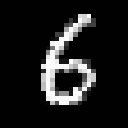

Mapped and Reconstructed Image


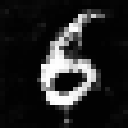

-----------------------
6832 images left
Label: 9
Iteration: 734 -- Reached Defined Optimum -- Final Loss: 59.99440002441406
Original Image


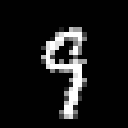

Mapped and Reconstructed Image


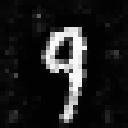

-----------------------
6831 images left
Label: 9
Iteration: 619 -- Reached Defined Optimum -- Final Loss: 59.98749923706055
Original Image


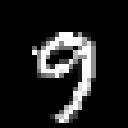

Mapped and Reconstructed Image


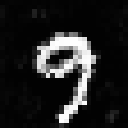

-----------------------
6830 images left
Label: 9
Iteration: 305 -- Reached Defined Optimum -- Final Loss: 59.938926696777344
Original Image


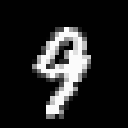

Mapped and Reconstructed Image


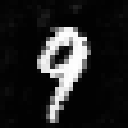

-----------------------
6829 images left
Label: 9
Iteration: 729 -- Reached Defined Optimum -- Final Loss: 59.994178771972656
CREATING CHECKPOINT...
Mounted at /content/drive
Original Image


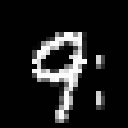

Mapped and Reconstructed Image


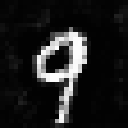

-----------------------
6828 images left
Label: 9
Iteration: 538 -- Reached Defined Optimum -- Final Loss: 59.983428955078125
Original Image


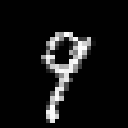

Mapped and Reconstructed Image


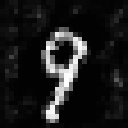

-----------------------
6827 images left
Label: 6
Iteration: 4483 -- Reached Defined Optimum -- Final Loss: 59.998329162597656
Original Image


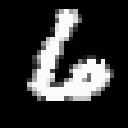

Mapped and Reconstructed Image


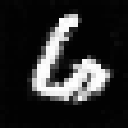

-----------------------
6826 images left
Label: 9
Iteration: 5000 -- Current Loss: 102.60089874267578 -- Current Learning-Rate: 0.01
Iteration: 10000 -- Current Loss: 96.2188949584961 -- Current Learning-Rate: 0.01
Iteration: 15000 -- Current Loss: 94.86223602294922 -- Current Learning-Rate: 0.01
Iteration: 19999 -- Current Loss: 93.83287048339844 -- Current Learning-Rate: 0.01
Original Image


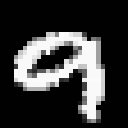

Mapped and Reconstructed Image


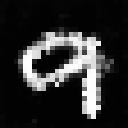

-----------------------
6825 images left
Label: 9
Iteration: 16 -- Reached Defined Optimum -- Final Loss: 59.640296936035156
Original Image


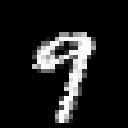

Mapped and Reconstructed Image


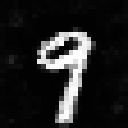

-----------------------
6824 images left
Label: 6
Iteration: 489 -- Reached Defined Optimum -- Final Loss: 59.917049407958984
Original Image


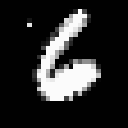

Mapped and Reconstructed Image


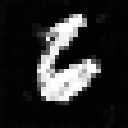

-----------------------
6823 images left
Label: 9
Iteration: 548 -- Reached Defined Optimum -- Final Loss: 59.98456573486328
Original Image


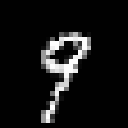

Mapped and Reconstructed Image


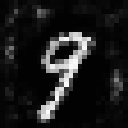

-----------------------
6822 images left
Label: 9
Iteration: 699 -- Reached Defined Optimum -- Final Loss: 59.98677444458008
Original Image


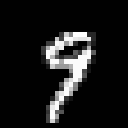

Mapped and Reconstructed Image


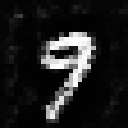

-----------------------
6821 images left
Label: 9
Iteration: 2500 -- Reached Defined Optimum -- Final Loss: 59.9957275390625
Original Image


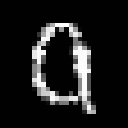

Mapped and Reconstructed Image


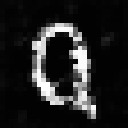

-----------------------
6820 images left
Label: 9
Iteration: 1281 -- Reached Defined Optimum -- Final Loss: 59.992584228515625
Original Image


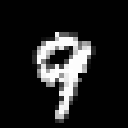

Mapped and Reconstructed Image


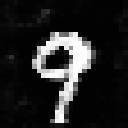

-----------------------
6819 images left
Label: 9
Iteration: 505 -- Reached Defined Optimum -- Final Loss: 59.945556640625
Original Image


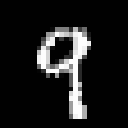

Mapped and Reconstructed Image


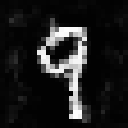

-----------------------
6818 images left
Label: 9
Iteration: 2927 -- Reached Defined Optimum -- Final Loss: 59.99903106689453
Original Image


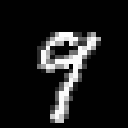

Mapped and Reconstructed Image


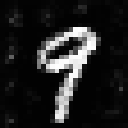

-----------------------
6817 images left
Label: 9
Iteration: 3187 -- Reached Defined Optimum -- Final Loss: 59.990631103515625
Original Image


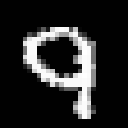

Mapped and Reconstructed Image


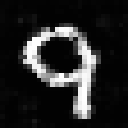

-----------------------
6816 images left
Label: 6
Iteration: 1413 -- Reached Defined Optimum -- Final Loss: 59.96089553833008
Original Image


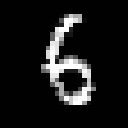

Mapped and Reconstructed Image


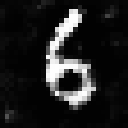

-----------------------
6815 images left
Label: 9
Iteration: 308 -- Reached Defined Optimum -- Final Loss: 59.844947814941406
Original Image


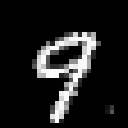

Mapped and Reconstructed Image


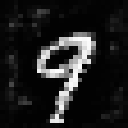

-----------------------
6814 images left
Label: 9
Iteration: 397 -- Reached Defined Optimum -- Final Loss: 59.776649475097656
Original Image


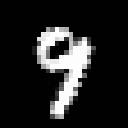

Mapped and Reconstructed Image


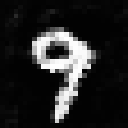

-----------------------
6813 images left
Label: 9
Iteration: 1586 -- Reached Defined Optimum -- Final Loss: 59.990211486816406
Original Image


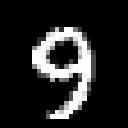

Mapped and Reconstructed Image


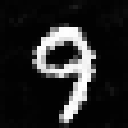

-----------------------
6812 images left
Label: 9
Iteration: 5000 -- Current Loss: 84.82537841796875 -- Current Learning-Rate: 0.01
Iteration: 10000 -- Current Loss: 80.4377212524414 -- Current Learning-Rate: 0.01
Iteration: 15000 -- Current Loss: 79.94511413574219 -- Current Learning-Rate: 0.01
Iteration: 19999 -- Current Loss: 79.45411682128906 -- Current Learning-Rate: 0.01
Original Image


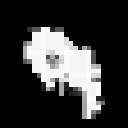

Mapped and Reconstructed Image


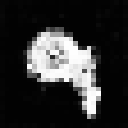

-----------------------
6811 images left
Label: 6
Iteration: 5000 -- Current Loss: 61.3169059753418 -- Current Learning-Rate: 0.01
Iteration: 5567 -- Reached Defined Optimum -- Final Loss: 59.99786376953125
Original Image


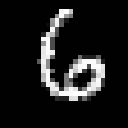

Mapped and Reconstructed Image


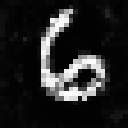

-----------------------
6810 images left
Label: 9
Iteration: 851 -- Reached Defined Optimum -- Final Loss: 59.99481964111328
Original Image


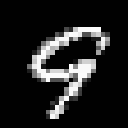

Mapped and Reconstructed Image


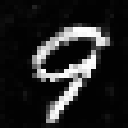

-----------------------
6809 images left
Label: 9
Iteration: 393 -- Reached Defined Optimum -- Final Loss: 59.898284912109375
Original Image


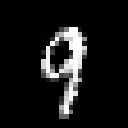

Mapped and Reconstructed Image


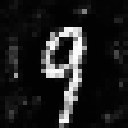

-----------------------
6808 images left
Label: 9
Iteration: 993 -- Reached Defined Optimum -- Final Loss: 59.984031677246094
Original Image


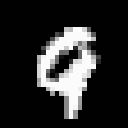

Mapped and Reconstructed Image


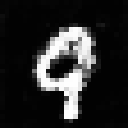

-----------------------
6807 images left
Label: 9
Iteration: 537 -- Reached Defined Optimum -- Final Loss: 59.93328094482422
Original Image


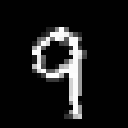

Mapped and Reconstructed Image


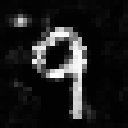

-----------------------
6806 images left
Label: 9
Iteration: 1186 -- Reached Defined Optimum -- Final Loss: 59.991661071777344
Original Image


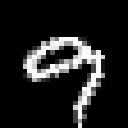

Mapped and Reconstructed Image


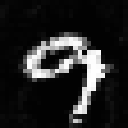

-----------------------
6805 images left
Label: 6
Iteration: 5000 -- Current Loss: 61.46531677246094 -- Current Learning-Rate: 0.01
Iteration: 5949 -- Reached Defined Optimum -- Final Loss: 59.99951171875
Original Image


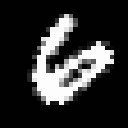

Mapped and Reconstructed Image


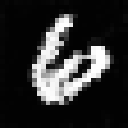

-----------------------
6804 images left
Label: 6
Iteration: 3786 -- Reached Defined Optimum -- Final Loss: 59.99895095825195
Original Image


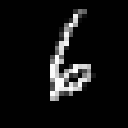

Mapped and Reconstructed Image


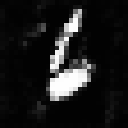

-----------------------
6803 images left
Label: 9
Iteration: 1720 -- Reached Defined Optimum -- Final Loss: 59.992210388183594
Original Image


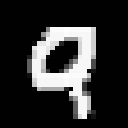

Mapped and Reconstructed Image


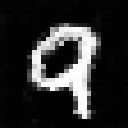

-----------------------
6802 images left
Label: 9
Iteration: 1130 -- Reached Defined Optimum -- Final Loss: 59.987003326416016
Original Image


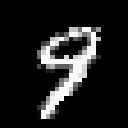

Mapped and Reconstructed Image


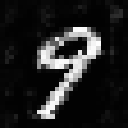

-----------------------
6801 images left
Label: 9
Iteration: 3509 -- Reached Defined Optimum -- Final Loss: 59.99881362915039
Original Image


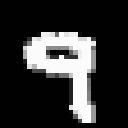

Mapped and Reconstructed Image


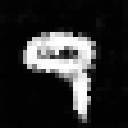

-----------------------
6800 images left
Label: 6
Iteration: 1145 -- Reached Defined Optimum -- Final Loss: 59.9881591796875
Original Image


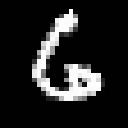

Mapped and Reconstructed Image


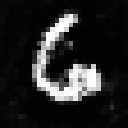

-----------------------
6799 images left
Label: 9
Iteration: 4721 -- Reached Defined Optimum -- Final Loss: 59.99680709838867
Original Image


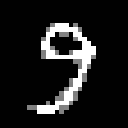

Mapped and Reconstructed Image


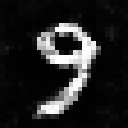

-----------------------
6798 images left
Label: 9
Iteration: 5000 -- Current Loss: 74.12107849121094 -- Current Learning-Rate: 0.01
Iteration: 10000 -- Current Loss: 68.37818145751953 -- Current Learning-Rate: 0.01
Iteration: 15000 -- Current Loss: 65.99808502197266 -- Current Learning-Rate: 0.01
Iteration: 19999 -- Current Loss: 64.41082763671875 -- Current Learning-Rate: 0.01
Original Image


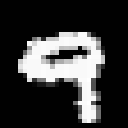

Mapped and Reconstructed Image


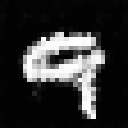

-----------------------
6797 images left
Label: 9
Iteration: 3228 -- Reached Defined Optimum -- Final Loss: 59.99949645996094
Original Image


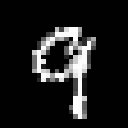

Mapped and Reconstructed Image


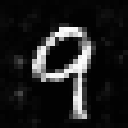

-----------------------
6796 images left
Label: 9
Iteration: 3989 -- Reached Defined Optimum -- Final Loss: 59.999794006347656
Original Image


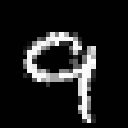

Mapped and Reconstructed Image


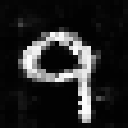

-----------------------
6795 images left
Label: 9
Iteration: 546 -- Reached Defined Optimum -- Final Loss: 59.89910125732422
Original Image


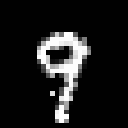

Mapped and Reconstructed Image


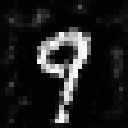

-----------------------
6794 images left
Label: 9
Iteration: 452 -- Reached Defined Optimum -- Final Loss: 59.88998031616211
Original Image


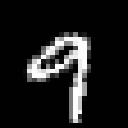

Mapped and Reconstructed Image


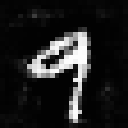

-----------------------
6793 images left
Label: 9
Iteration: 803 -- Reached Defined Optimum -- Final Loss: 59.986793518066406
Original Image


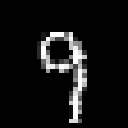

Mapped and Reconstructed Image


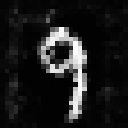

-----------------------
6792 images left
Label: 6
Iteration: 376 -- Reached Defined Optimum -- Final Loss: 59.933677673339844
Original Image


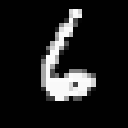

Mapped and Reconstructed Image


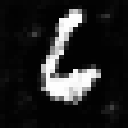

-----------------------
6791 images left
Label: 9
Iteration: 523 -- Reached Defined Optimum -- Final Loss: 59.96478271484375
Original Image


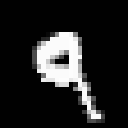

Mapped and Reconstructed Image


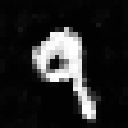

-----------------------
6790 images left
Label: 9
Iteration: 5000 -- Current Loss: 69.83541107177734 -- Current Learning-Rate: 0.01


In [ ]:
while counter > 0:
    if i % 50 == 0 and i != 0:
        clear_output()
        print("Cleared Output...")

    print(f"{counter} images left")
    print(f"Label: {d[1]['label'].item()}")

    max_retries = 5
    opt_threshold=60
    ignore_rules_below_threshold=75
    immediate_retry_threshold=110
    max_opt_iterations=20000

    if (d[1]['anomaly'].item() == True and map_anomalies) or (d[1]['anomaly'].item() == False and map_normals):
        mapped_z, reconstruction_loss, retry = lsm.map_image_to_point_in_latent_space(d[0][0],
                                                                            batch_size=1,
                                                                            max_opt_iterations=max_opt_iterations,
                                                                            plateu_threshold=0.0005,
                                                                            check_every_n_iter=5000,
                                                                            learning_rate=0.01,
                                                                            print_every_n_iters=5000,
                                                                            retry_after_n_iters=30000,
                                                                            ignore_rules_below_threshold=ignore_rules_below_threshold,
                                                                            opt_threshold=opt_threshold,
                                                                            immediate_retry_threshold=immediate_retry_threshold)

        if retry:
            if retry_counter == max_retries:
                retry_counter = 0
                i+=1
                counter-=1
                print("Retry Limit reached. Moving on to next sample")
                print('Original Image That Could Not Be Mapped')
                display(t(original_img[0]).resize((128, 128), PIL.Image.NEAREST))
                d = next(iterator)
                print('-----------------------')
                continue
            else:
                retry_counter += 1
                print(f"Could not find optimal region within the defined iteration count. Retry ({retry_counter}) with another random z...")
                continue

        retry_counter = 0
        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', d[1]['label'].item(), math.floor(reconstruction_loss)]
            writer.writerow(fields)

        torch.save(mapped_z, os.path.join(base_folder, f'mapped_z_{counter}.pt'))
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
            create_cp(counter)
            clear_output

        print('Original Image')
        display(t(d[0][0]).resize((128, 128), PIL.Image.NEAREST))
        print('Mapped and Reconstructed Image')
        original_img = generator(mapped_z).cpu()
        display(t(original_img[0]).resize((128, 128), PIL.Image.NEAREST))
        print('-----------------------')

    i+=1
    counter-=1
    d = next(iterator)

create_cp(0)